In [57]:
import pandas as pd
import polars as pl
import numpy as np
import time
import matplotlib.pyplot as plt
import graphviz

In [75]:
def spam_data(rows):
    data = {
        "A": np.random.randint(1,100,size=rows),
        "B": np.random.rand(rows),
        "C": np.random.choice(("X", "Y", "Z"), size=rows)
    }
    return pd.DataFrame(data)

rows = 10 ** 6
df_pd = spam_data(rows)
df_pl = pl.DataFrame(df_pd)
lazy_df = df_pl.lazy()

df_pd.head(3)

,A,B,C
0,36,0.361177,Y
1,2,0.135574,X
2,64,0.029558,Z


Pandas results:
    C         B
0  X  0.499335
1  Y  0.499146
2  Z  0.500485
Polars results:
    C         B
0  X  0.499335
1  Y  0.499146
2  Z  0.500485
Polars lazy results: 
    C         B
0  X  0.499335
1  Y  0.499146
2  Z  0.500485


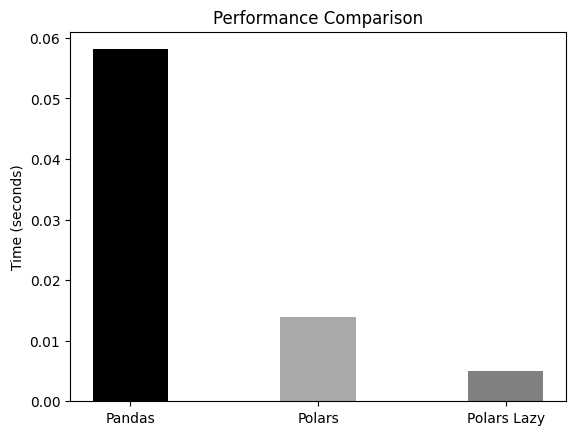

In [77]:

'''
Pandas
'''
start = time.time()
filtered_pd = df_pd[df_pd["A"] > 50]
res_pd = (
    filtered_pd.groupby("C")
    .agg({"B":"mean"})
    .reset_index()
)
pd_time = time.time() - start

'''
Polars
'''
start_pl = time.time()
filtered_pl = df_pl.filter(pl.col("A")>50)
res_pl = (
    filtered_pl.group_by("C")
    .agg(pl.mean("B"))
    .sort("C")
    .to_pandas()
)
pl_time=time.time() - start_pl

'''
Polars lazy
'''
start_lazy = time.time()
res_lazy = (
    lazy_df
    .filter(pl.col("A") > 50)
    .group_by("C")
    .agg(pl.mean("B"))
    .sort("C")
)
collect_start = time.time()
res_lazy = res_lazy.collect().to_pandas()
lazy_time = time.time() - start_lazy
collect_time = time.time() - collect_start

print(f"Pandas results:\n {res_pd}")
print(f"Polars results:\n {res_pl}")
print(f"Polars lazy results: \n {res_lazy}")

operations = ["Pandas", "Polars", "Polars Lazy"]
times = [pd_time, pl_time, lazy_time]
x = np.arange(len(operations))

plt.bar(x, times, width=0.4, color=['black', 'darkgrey', 'grey'], tick_label=operations)
plt.ylabel("Time (seconds)")
plt.title("Performance Comparison")
plt.show()

In [79]:
#Pandas
start_time = time.time()
df_pd = pd.read_csv("dataset.csv")
end_time = time.time()

execution_time = end_time - start_time
print(f"Pandas Execution time: {execution_time:.6f} seconds")

#Polars
start_time = time.time()
df_pl = pl.read_csv("dataset.csv")
end_time = time.time()

execution_time = end_time - start_time
print(f"Polars Execution time: {execution_time:.6f} seconds")

# Polars LF
start_time = time.time()
lazy_df = pl.read_csv("dataset.csv").lazy()
end_time = time.time()

execution_time = end_time - start_time
print(f"Polars LazyFrame Execution time: {execution_time:.6f} seconds")

Pandas Execution time: 31.078026 seconds
Polars Execution time: 19.242140 seconds
Polars LazyFrame Execution time: 12.375363 seconds


In [80]:
df_pl.head(1)

app_id,app_name,review_text,review_score,review_votes
i64,str,str,i64,i64
10,"""Counter-Strike""","""Ruined my life.""",1,0


In [66]:
# Pandas
start_time = time.time()
result = (
    df_pd.assign(text_length=df_pd["review_text"].str.len())
    .groupby("app_name", as_index=True)
    .agg(avg_text_length=("text_length", "mean"))
    .sort_values("avg_text_length", ascending=False)
)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")
print(result.head(3))

Execution time: 21.311403 seconds
                                                    avg_text_length
app_name                                                           
Dark Parables: The Swan Princess and The Dire T...           7403.0
Tremor                                                       4262.5
Massive Assault Network 2                                    4017.5


In [70]:
# Polars DF
start_time = time.time()
result = (
    df_pl.with_columns(
        pl.col("review_text").str.len_chars().alias("text_length")
    )
    .group_by("app_name")
    .agg(
        pl.col("text_length").mean().alias("avg_text_length")
    )
    .sort("avg_text_length", descending=True)
)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")
print(result.head(3))

Execution time: 4.917652 seconds
shape: (3, 2)
┌─────────────────────────────────┬─────────────────┐
│ app_name                        ┆ avg_text_length │
│ ---                             ┆ ---             │
│ str                             ┆ f64             │
╞═════════════════════════════════╪═════════════════╡
│ Dark Parables: The Swan Prince… ┆ 7403.0          │
│ Tremor                          ┆ 4262.5          │
│ Massive Assault Network 2       ┆ 4017.5          │
└─────────────────────────────────┴─────────────────┘


In [74]:
# Polars LF
start_time = time.time()

result = (
    df_pl.lazy()
    .with_columns(
        pl.col("review_text").str.len_chars().alias("text_length")
    )
    .group_by("app_name")
    .agg(
        pl.col("text_length").mean().alias("avg_text_length")
    )
    .sort("avg_text_length", descending=True)
    .collect()
)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")
print(result.head(3))

Execution time: 2.793241 seconds
shape: (3, 2)
┌─────────────────────────────────┬─────────────────┐
│ app_name                        ┆ avg_text_length │
│ ---                             ┆ ---             │
│ str                             ┆ f64             │
╞═════════════════════════════════╪═════════════════╡
│ Dark Parables: The Swan Prince… ┆ 7403.0          │
│ Tremor                          ┆ 4262.5          │
│ Massive Assault Network 2       ┆ 4017.5          │
└─────────────────────────────────┴─────────────────┘
